        datetime   PM10   SO2   NO2   O3   CO  Relative_Humidity_2m(%)  \
0  2020/1/1 0:00   77.0  24.0  57.0  9.0  1.5                       25   
1  2020/1/1 1:00   84.0  21.0  56.0  8.0  1.3                       24   
2  2020/1/1 2:00   97.0  24.0  58.0  8.0  1.5                       25   
3  2020/1/1 3:00  107.0  29.0  62.0  9.0  1.6                       24   
4  2020/1/1 4:00  109.0  26.0  60.0  9.0  1.5                       25   

   Temperature  Target  
0         -8.9    54.0  
1         -8.3    51.0  
2         -8.6    55.0  
3         -7.9    60.0  
4         -8.8    59.0  
(41424, 9)


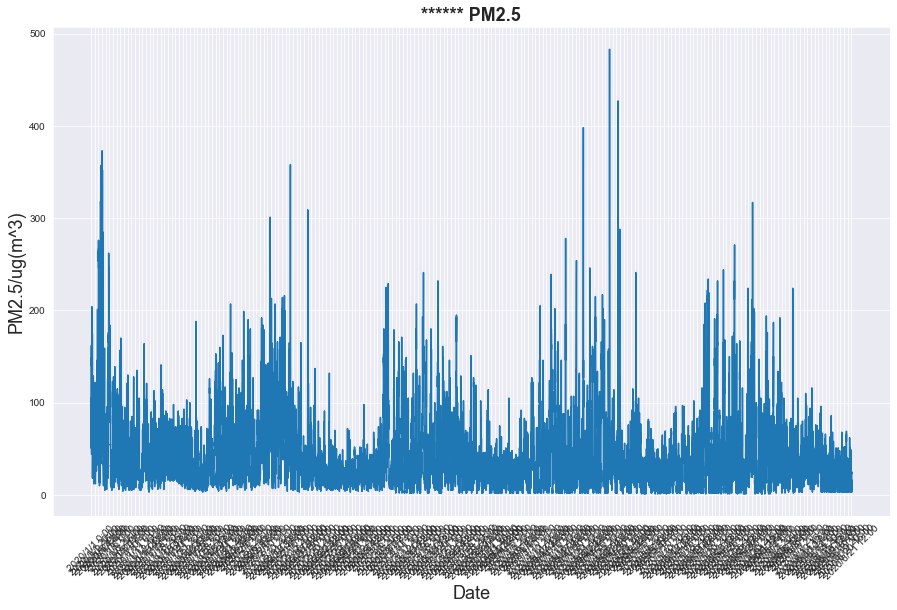

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

filepath = '../data/DataProcess/station/1037A/1037A_final.csv'
data = pd.read_csv(filepath)
#data = data.sort_values('Date')
print(data.head())
print(data.shape)

sns.set_style("darkgrid")
plt.figure(figsize=(15, 9))
plt.plot(data[['Target']])
plt.xticks(range(0, data.shape[0], 200), data['datetime'].loc[::20], rotation=45)
plt.title("****** PM2.5", fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=18)
plt.ylabel('PM2.5/ug(m^3)', fontsize=18)
plt.show()

## 1.特征工程

In [2]:
price = data[['Target']]
print(price.info())

from sklearn.preprocessing import MinMaxScaler
# 进行不同的数据缩放，将数据缩放到-1和1之间
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Target'] = scaler.fit_transform(price['Target'].values.reshape(-1, 1))
print(price['Target'].shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41424 entries, 0 to 41423
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Target  41424 non-null  float64
dtypes: float64(1)
memory usage: 323.8 KB
None
(41424,)


C:\Anaconda\envs\graduate\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## 2.数据集制作

In [3]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []
    # print(data)

    # you can free play（seq_length）
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]

    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :]

    return [x_train, y_train, x_test, y_test]

lookback = 20
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

x_train.shape =  (33123, 19, 1)
y_train.shape =  (33123, 1)
x_test.shape =  (8281, 19, 1)
y_test.shape =  (8281, 1)


## 3.模型构建 —— CNN_LSTM_KAN

In [4]:
import torch
import torch.nn as nn
#from kan import KAN

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)
input_dim = 1
# 隐藏层特征的维度
hidden_dim = 32
# 循环的layers
num_layers = 4
output_dim = 1
num_epochs = 50


class CNN_LSTM(nn.Module):
    def __init__(self, in_channels,hidden_size,num_layers,out_channels,output_size):
        super(CNN_LSTM, self).__init__()
        # self.args = args
        self.relu = nn.ReLU(inplace=True)
        # (batch_size=30, seq_len=24, input_size=7) ---> permute(0, 2, 1)
        # (30, 7, 24)
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=1)
        )
        # (batch_size=30, out_channels=32, seq_len-4=20) ---> permute(0, 2, 1)
        # (30, 20, 32)
        self.lstm = nn.LSTM(input_size=out_channels, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = self.fc(x)
        x = x[:, -1, :]

        return x




model = CNN_LSTM(in_channels=input_dim, hidden_size=hidden_dim, num_layers=num_layers,out_channels=32,output_size=output_dim)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

## 4.模型训练

In [5]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time() - start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.6426405906677246
Epoch  1 MSE:  0.6127442121505737
Epoch  2 MSE:  0.5834158658981323
Epoch  3 MSE:  0.5544228553771973
Epoch  4 MSE:  0.5255027413368225
Training time: 18.166436910629272


## 5.模型结果可视化

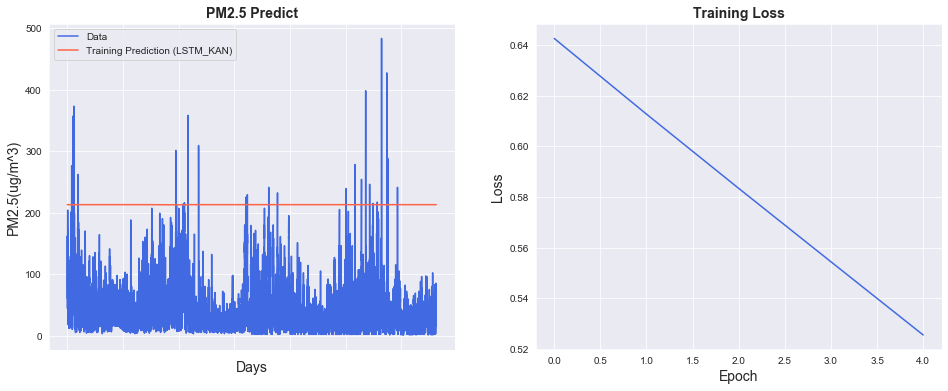

In [6]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM_KAN)", color='tomato')
# print(predict.index)
# print(predict[0])


ax.set_title('PM2.5 Predict', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("PM2.5(ug/m^3)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)
plt.show()

## 6.模型验证

In [7]:
# print(x_test[-1])
import math, time
from sklearn.metrics import mean_squared_error,r2_score

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

trainr2Score = r2_score(y_train[:,0], y_train_pred[:,0])
print('Train Score: %.2f R2' % (trainr2Score))
testr2Score = r2_score(y_test[:,0], y_test_pred[:,0])
print('Test Score: %.2f R2' % (testr2Score))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Target'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

Train Score: 174.70 RMSE
Test Score: 168.29 RMSE
Train Score: -19.81 R2
Test Score: -17.23 R2


## 7. 绘制图像

In [31]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='PM2.5(ug/m^3)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (CNN_LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()